## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-axial' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
horizontal_wavelet_axial_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/axial/wavelet/horizontal'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4,
 3: 20050,
 4: 180942,
 5: 922650,
 6: 4185552,
 7: 17688454,
 8: 72685058,
 9: 295085108}

Running 12760 CDFs


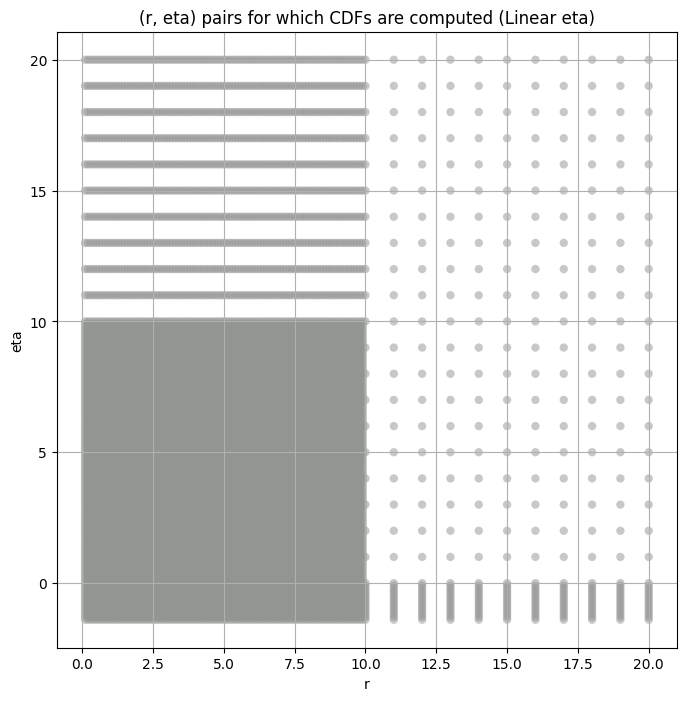

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:31<00:00, 3214.64it/s]


Layer 3


100%|██████████| 100000/100000 [00:49<00:00, 2004.41it/s]


Layer 4


100%|██████████| 100000/100000 [00:43<00:00, 2318.29it/s]


Layer 5


100%|██████████| 100000/100000 [00:45<00:00, 2177.41it/s]


Layer 6


100%|██████████| 100000/100000 [00:43<00:00, 2292.25it/s]


Layer 7


100%|██████████| 100000/100000 [00:51<00:00, 1951.55it/s]


Layer 8


100%|██████████| 100000/100000 [01:02<00:00, 1592.67it/s]


Layer 9


100%|██████████| 100000/100000 [02:22<00:00, 699.77it/s]


obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      141835.42000       0.000000  209363.500000  -1.773327         NaN   
3      736888.25000  720600.400000  753057.440000  -1.273360   -1.335994   
4      465364.94000  445307.280000  485416.300000   0.833817    0.715541   
5      108863.67000  102563.990000  115377.720000   3.237579    2.714865   
6       47217.00800   43791.793000   50738.293000   6.127006    5.564620   
7        9147.37000    8511.857000    9801.893000   5.521395    5.010843   
8         918.85600     848.677900     993.557400   7.177231    5.903591   
9          78.33318      70.408485      87.402626  15.242443   10.448604   

       kurt_upper  total_samples  
layer                             
2             NaN            4.0  
3       -1.193485        20050.0  
4        0.964410       180942.0  
5        3.808384       922650.0  
6        6.721844      4185552.0  
7        6.145352     17688454.0  
8       11.476420     72685058.0  
9       33.768715    295085108.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      141835.42000  141835.421875             NaN             NaN   
3      736888.25000  736888.250000   726981.437500   722051.500000   
4      465364.94000  465364.937500   462751.875000   460612.718750   
5      108863.67000  108863.671875   107235.117188   105914.687500   
6       47217.00800   47217.007812    46511.144531    45899.308594   
7        9147.37000    9147.370117     9018.760742     8912.322266   
8         918.85600     918.856018      898.288086      884.455994   
9          78.33318      78.333183       75.012680       73.066254   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3       717541.000000    713251.000000    705198.500000    697715.875000   
4       458558.125000    456558.718750    452692.750000    448952.906250   
5       104718.359375    103606.335938    101586.140625     99765.203125   
6        45327.824219     44782.910156     43753.871094     42790.136719   
7         8813.821289      8720.596680      8545.362305      8381.167969   
8          872.058472       860.555420       839.442566       820.141663   
9           71.374565        69.847870        67.136375        64.755882   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3        690563.937500    683676.500000    677026.437500    657967.312500  
4        445311.031250    441740.593750    438235.468750    428040.687500  
5         98110.671875     96606.312500     95220.265625     91580.843750  
6         41879.582031     41013.265625     40184.363281     37885.773438  
7          8225.524414      8076.956055      7934.352051      7535.826660  
8           802.193115       785.320740       769.350952       725.782471  
9            62.621086        60.681671        58.902050        54.303211

####
Layer  2


100%|██████████| 12760/12760 [00:00<00:00, 15355.27it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.2662167151227164 141835.42


100%|██████████| 12760/12760 [00:00<00:00, 25186.62it/s]


Finding Minimum after computing 12760 CDFs
2 25 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 28607.49it/s]


Finding Minimum after computing 12760 CDFs
2 50 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 30904.56it/s]


Finding Minimum after computing 12760 CDFs
2 75 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31382.41it/s]


Finding Minimum after computing 12760 CDFs
2 100 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31403.35it/s]


Finding Minimum after computing 12760 CDFs
2 150 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31469.35it/s]


Finding Minimum after computing 12760 CDFs
2 200 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31443.06it/s]


Finding Minimum after computing 12760 CDFs
2 250 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31407.74it/s]


Finding Minimum after computing 12760 CDFs
2 300 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31507.05it/s]


Finding Minimum after computing 12760 CDFs
2 350 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 31518.55it/s]


Finding Minimum after computing 12760 CDFs
2 500 nan nan
Number of samples: 4, Without approximation : 4.0


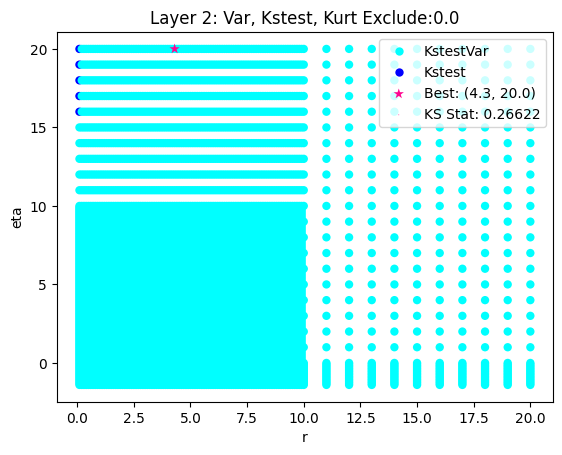

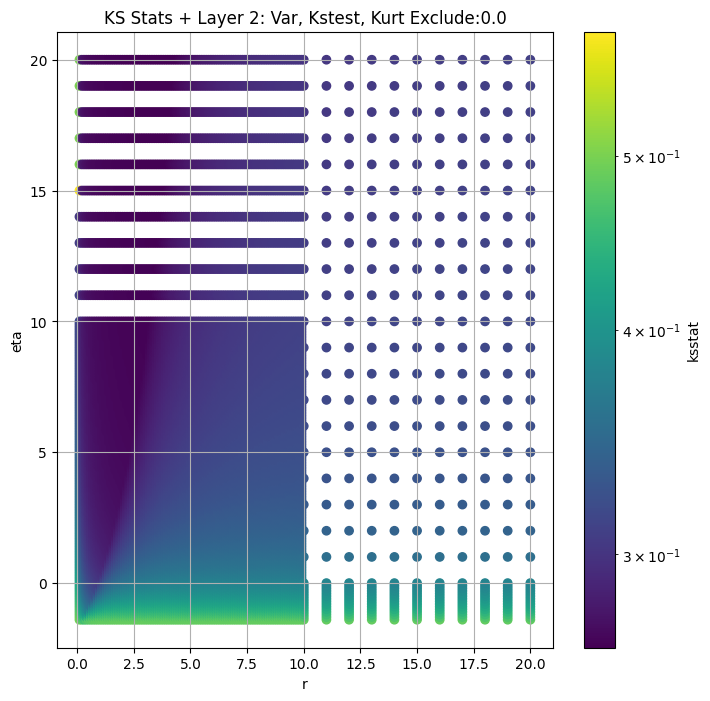

####
Layer  3


100%|██████████| 12760/12760 [00:08<00:00, 1450.35it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.08868665620120297 736888.25


100%|██████████| 12760/12760 [00:08<00:00, 1459.35it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.08999376869786002 726981.44


100%|██████████| 12760/12760 [00:09<00:00, 1408.04it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.09065310024928469 722051.5


100%|██████████| 12760/12760 [00:08<00:00, 1456.53it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.09126160285998558 717541.0


100%|██████████| 12760/12760 [00:08<00:00, 1443.71it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.09184509381978495 713251.0


100%|██████████| 12760/12760 [00:08<00:00, 1447.53it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.09295301355868313 705198.5


100%|██████████| 12760/12760 [00:08<00:00, 1418.26it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.09383382513904748 697715.9


100%|██████████| 12760/12760 [00:08<00:00, 1442.17it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.09484595692049691 690563.94


100%|██████████| 12760/12760 [00:08<00:00, 1442.49it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.09583385177689074 683676.5


100%|██████████| 12760/12760 [00:08<00:00, 1448.33it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.09683688330690732 677026.44


100%|██████████| 12760/12760 [00:08<00:00, 1453.75it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.0998063153979869 657967.3
Number of samples: 20050, Without approximation : 20050.0


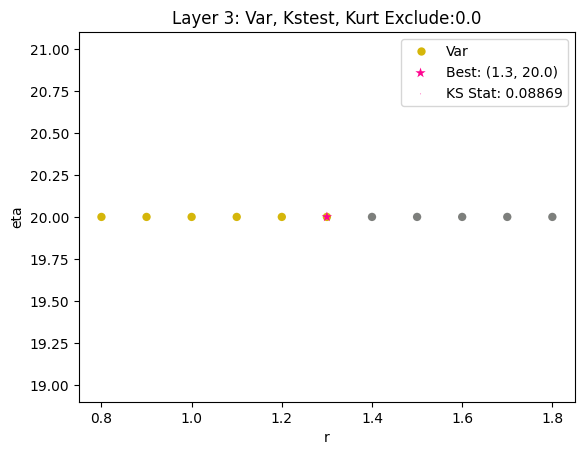

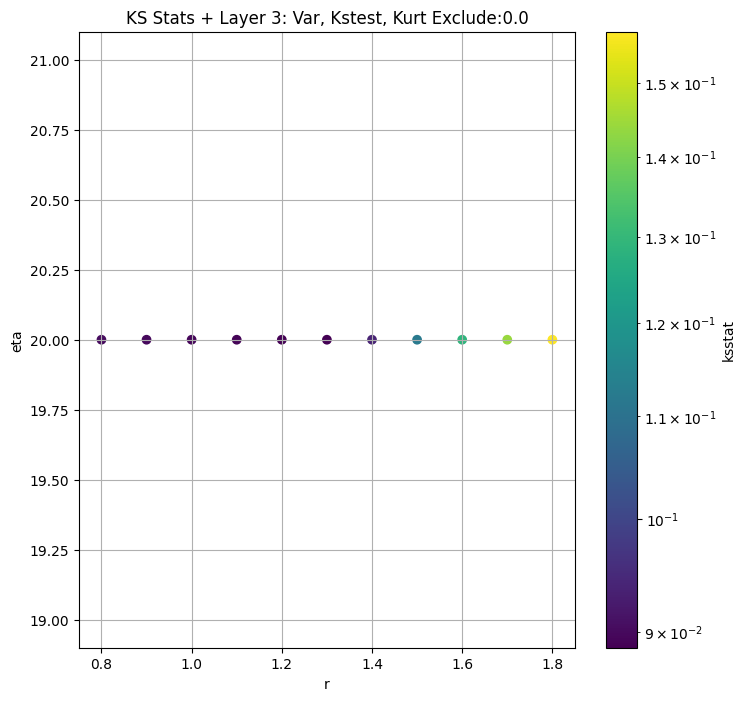

####
Layer  4


100%|██████████| 12760/12760 [00:42<00:00, 301.44it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.014599456366395591 465364.94


100%|██████████| 12760/12760 [00:43<00:00, 295.64it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.014599456366395591 462751.88


100%|██████████| 12760/12760 [00:43<00:00, 293.56it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.014599456366395591 460612.72


100%|██████████| 12760/12760 [00:42<00:00, 298.54it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.014599456366395591 458558.12


100%|██████████| 12760/12760 [00:42<00:00, 300.30it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.014599456366395591 456558.72


100%|██████████| 12760/12760 [00:42<00:00, 297.24it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.014599456366395591 452692.75


100%|██████████| 12760/12760 [00:42<00:00, 297.17it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.014303026388052975 448952.9


100%|██████████| 12760/12760 [00:45<00:00, 283.33it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.01385525325084784 445311.03


100%|██████████| 12760/12760 [00:44<00:00, 287.67it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.014147664218828435 441740.6


100%|██████████| 12760/12760 [00:43<00:00, 296.09it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.014497590146236125 438235.47


100%|██████████| 12760/12760 [00:42<00:00, 300.57it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.015507368200376733 428040.7
Number of samples: 100000, Without approximation : 180942.0


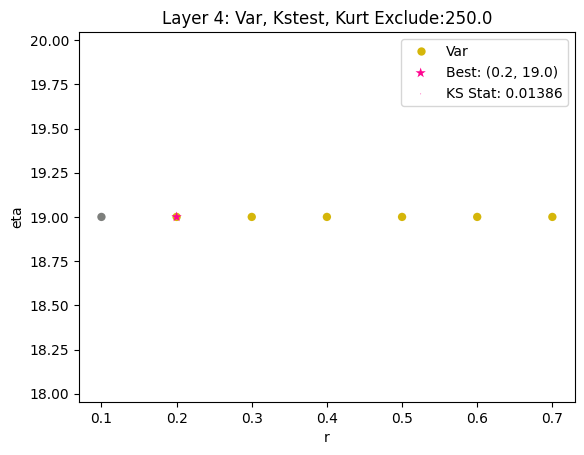

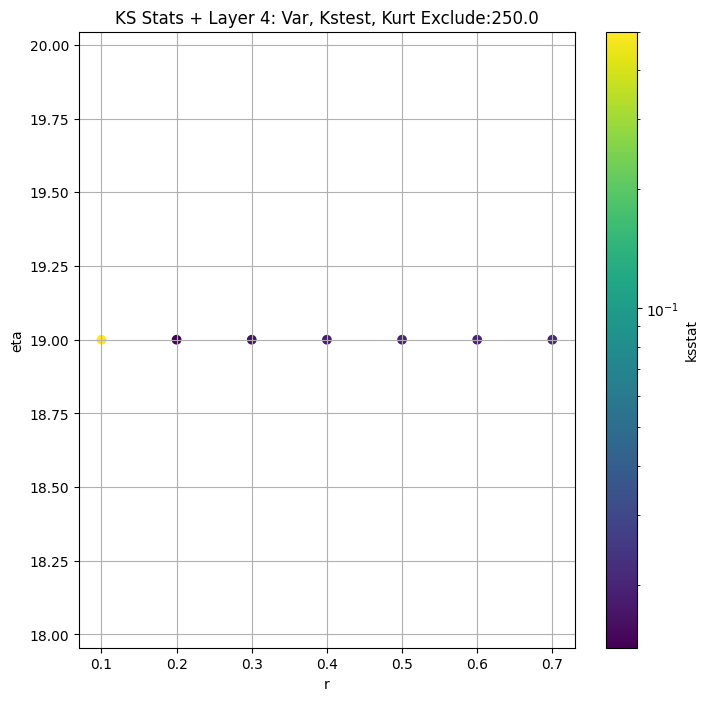

####
Layer  5


100%|██████████| 12760/12760 [00:42<00:00, 299.47it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.004729830889967729 108863.67


100%|██████████| 12760/12760 [00:42<00:00, 298.87it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.004738666870042596 107235.12


100%|██████████| 12760/12760 [00:42<00:00, 299.71it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.004236326358720677 105914.69


100%|██████████| 12760/12760 [00:42<00:00, 299.98it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.004435580469376706 104718.36


100%|██████████| 12760/12760 [00:42<00:00, 300.47it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.004784184395906797 103606.336


100%|██████████| 12760/12760 [00:42<00:00, 299.87it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.005539365544730113 101586.14


100%|██████████| 12760/12760 [00:44<00:00, 288.40it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.0062154993387577295 99765.2


100%|██████████| 12760/12760 [00:43<00:00, 293.37it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.006747645625027832 98110.67


100%|██████████| 12760/12760 [00:43<00:00, 293.17it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.007243372754019831 96606.31


100%|██████████| 12760/12760 [00:44<00:00, 283.85it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.007830319139844333 95220.266


100%|██████████| 12760/12760 [00:44<00:00, 289.48it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.009339641351813428 91580.84
Number of samples: 100000, Without approximation : 922650.0


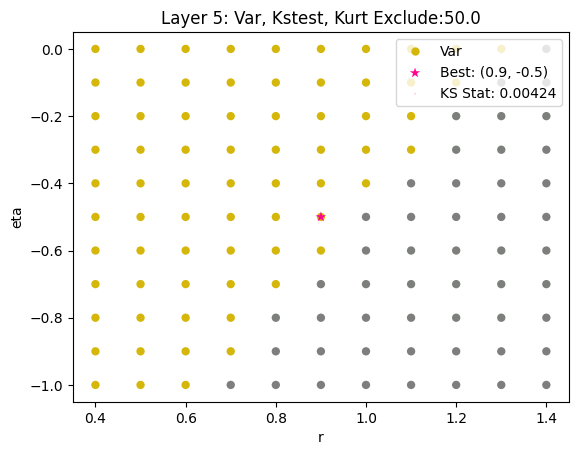

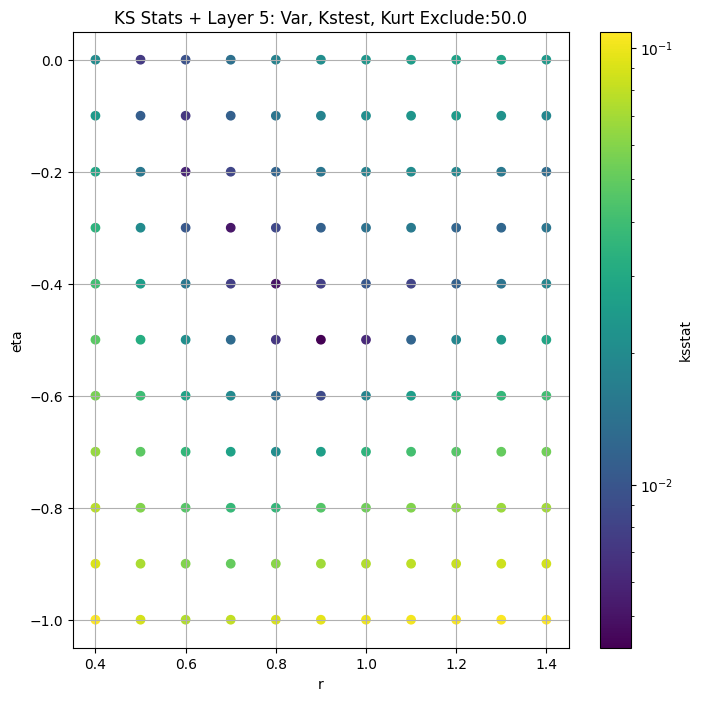

####
Layer  6


100%|██████████| 12760/12760 [00:42<00:00, 297.73it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.010449600577464802 47217.008


100%|██████████| 12760/12760 [00:42<00:00, 300.28it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.009966021467573749 46511.145


100%|██████████| 12760/12760 [00:42<00:00, 301.71it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.009547315660156708 45899.31


100%|██████████| 12760/12760 [00:43<00:00, 295.95it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.00914937353956502 45327.824


100%|██████████| 12760/12760 [00:42<00:00, 300.07it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.008782918847513144 44782.91


100%|██████████| 12760/12760 [00:42<00:00, 299.61it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.010397892763202687 43753.87


100%|██████████| 12760/12760 [00:43<00:00, 296.18it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.010340252840528419 42790.137


100%|██████████| 12760/12760 [00:42<00:00, 299.83it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.009400091142820033 41879.582


100%|██████████| 12760/12760 [00:42<00:00, 300.46it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.008673020829661038 41013.266


100%|██████████| 12760/12760 [00:42<00:00, 301.19it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.00805750574780928 40184.363


100%|██████████| 12760/12760 [00:42<00:00, 300.40it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.009294945846611391 37885.773
Number of samples: 100000, Without approximation : 4185552.0


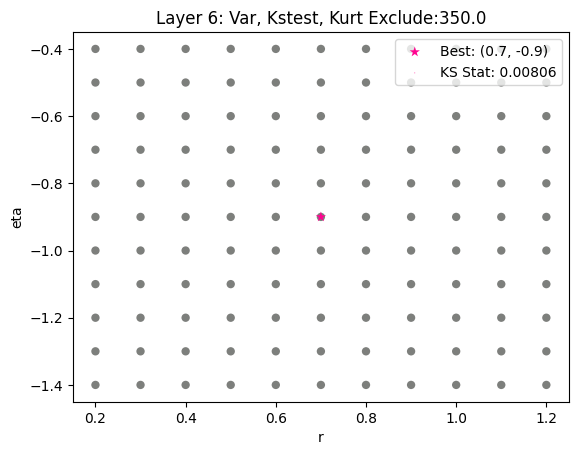

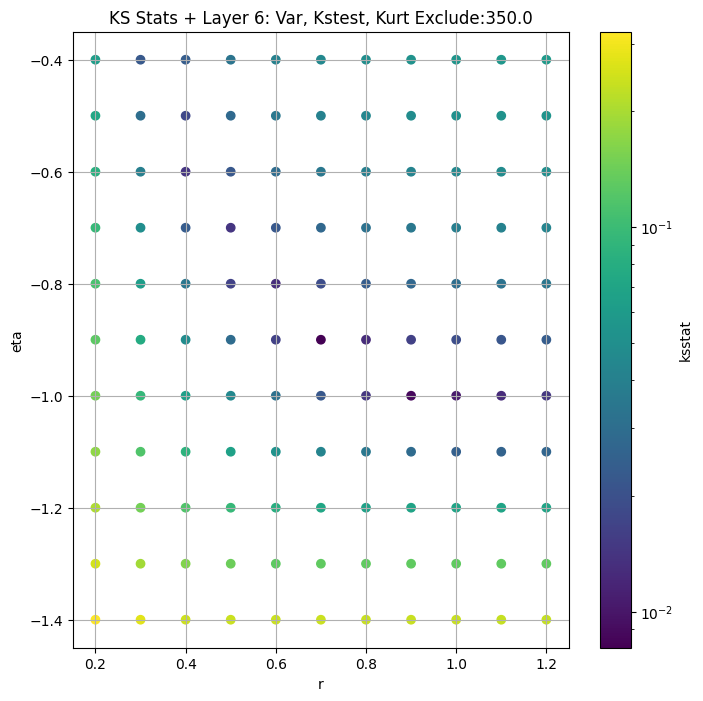

####
Layer  7


100%|██████████| 12760/12760 [00:42<00:00, 299.80it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.010897624968888922 9147.37


100%|██████████| 12760/12760 [00:42<00:00, 301.11it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.01002429529698283 9018.761


100%|██████████| 12760/12760 [00:42<00:00, 299.76it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.009754353725120346 8912.322


100%|██████████| 12760/12760 [00:42<00:00, 301.77it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.009873817309203559 8813.821


100%|██████████| 12760/12760 [00:42<00:00, 301.57it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.009988531563244307 8720.597


100%|██████████| 12760/12760 [00:42<00:00, 297.99it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.010269953947621133 8545.362


100%|██████████| 12760/12760 [00:46<00:00, 275.00it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.010883884204904881 8381.168


100%|██████████| 12760/12760 [00:45<00:00, 282.58it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.011471213384513942 8225.524


100%|██████████| 12760/12760 [00:44<00:00, 285.16it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.011536438386962444 8076.956


100%|██████████| 12760/12760 [00:44<00:00, 289.97it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.011937438436032233 7934.352


100%|██████████| 12760/12760 [00:43<00:00, 290.76it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.013409063519459863 7535.8267
Number of samples: 100000, Without approximation : 17688454.0


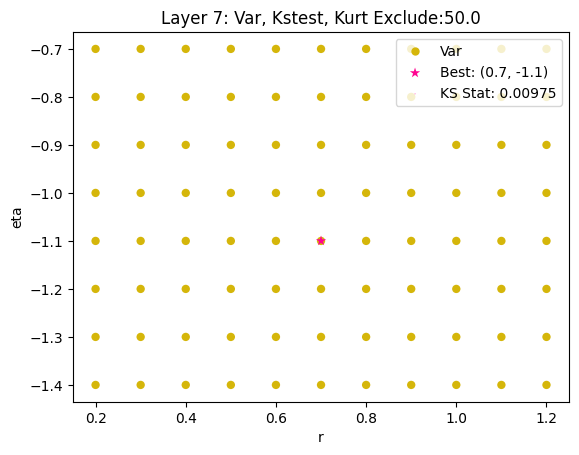

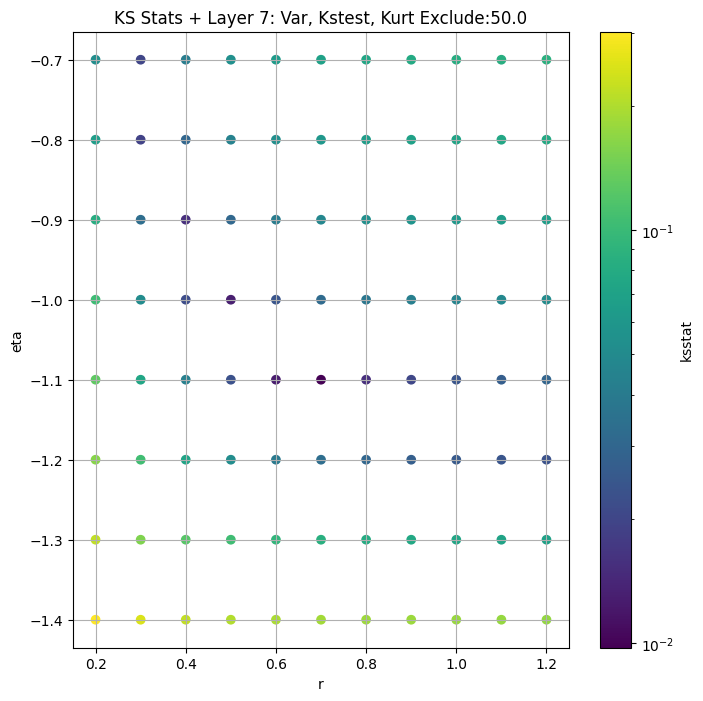

####
Layer  8


100%|██████████| 12760/12760 [00:44<00:00, 287.41it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.01493593897068124 918.856


100%|██████████| 12760/12760 [00:43<00:00, 290.20it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.014935892741504753 898.2881


100%|██████████| 12760/12760 [00:43<00:00, 290.88it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.015108681475834496 884.456


100%|██████████| 12760/12760 [00:44<00:00, 288.09it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.015360984828309943 872.0585


100%|██████████| 12760/12760 [00:45<00:00, 277.39it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.01559938943568151 860.5554


100%|██████████| 12760/12760 [00:43<00:00, 290.77it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.01604818527613111 839.44257


100%|██████████| 12760/12760 [00:44<00:00, 287.33it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.016792057949506778 820.14166


100%|██████████| 12760/12760 [00:45<00:00, 277.94it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.017474828549488397 802.1931


100%|██████████| 12760/12760 [00:43<00:00, 290.69it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.01661678117639187 785.32074


100%|██████████| 12760/12760 [00:44<00:00, 283.64it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.01578339473577861 769.35095


100%|██████████| 12760/12760 [00:45<00:00, 281.88it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.016268569670542743 725.7825
Number of samples: 100000, Without approximation : 72685058.0


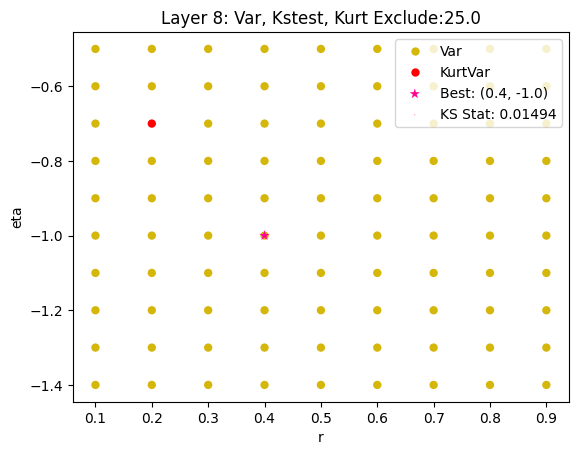

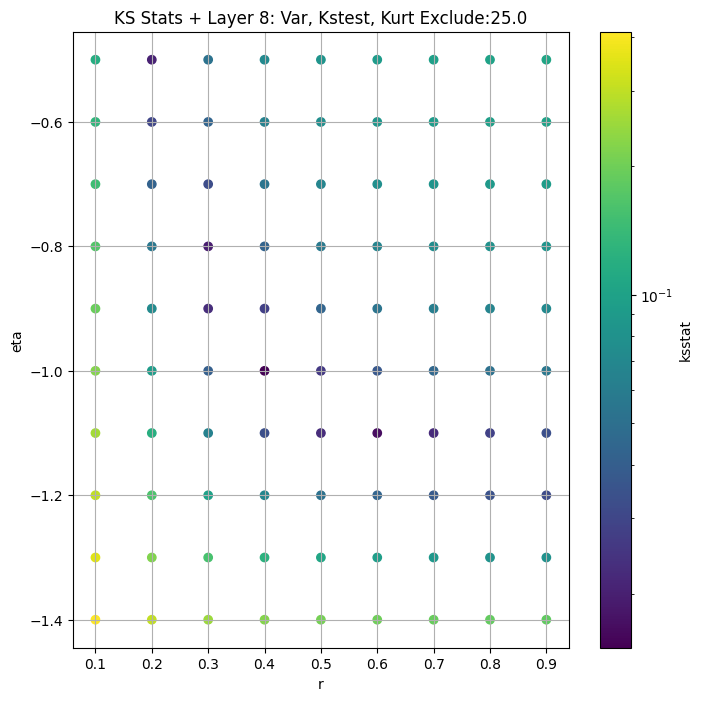

####
Layer  9


100%|██████████| 12760/12760 [00:44<00:00, 287.15it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.09081793863625537 78.33318


100%|██████████| 12760/12760 [00:44<00:00, 287.62it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.09081307879582878 75.01268


100%|██████████| 12760/12760 [00:44<00:00, 288.37it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.09081007731635038 73.06625


100%|██████████| 12760/12760 [00:44<00:00, 289.28it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.09080736957687308 71.374565


100%|██████████| 12760/12760 [00:43<00:00, 291.11it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.09080484198545918 69.84787


100%|██████████| 12760/12760 [00:43<00:00, 292.19it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.09080014218568078 67.136375


100%|██████████| 12760/12760 [00:43<00:00, 296.27it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.09079577515499648 64.75588


100%|██████████| 12760/12760 [00:44<00:00, 289.60it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.09079164899348302 62.621086


100%|██████████| 12760/12760 [00:43<00:00, 293.77it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.09078771331971547 60.68167


100%|██████████| 12760/12760 [00:43<00:00, 294.55it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.0907839322850943 58.90205


100%|██████████| 12760/12760 [00:43<00:00, 293.44it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.09078790961194039 54.30321
Number of samples: 100000, Without approximation : 295085108.0


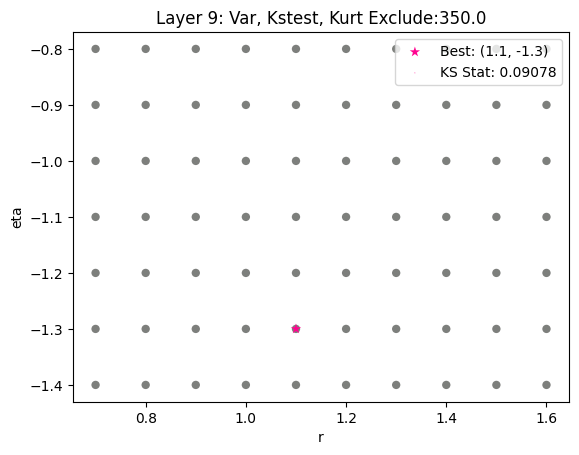

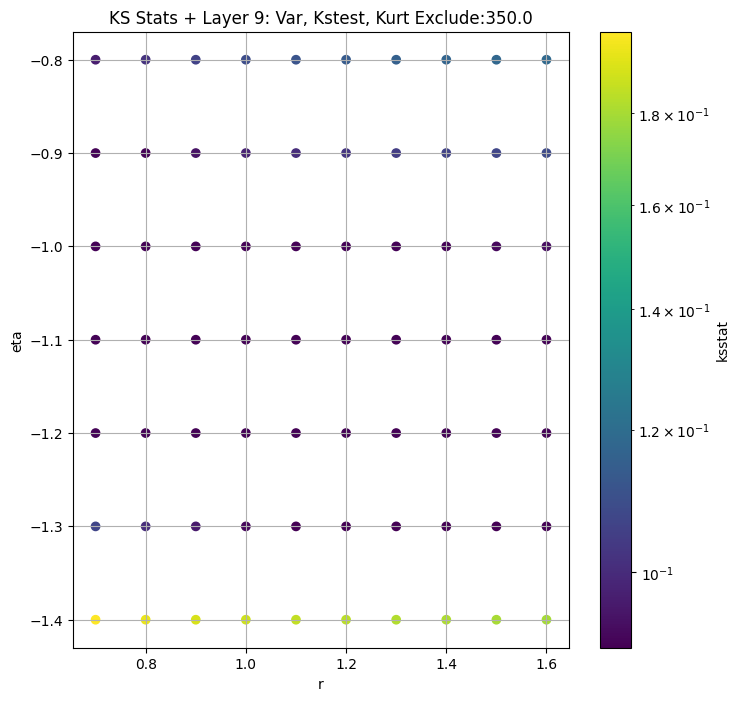

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      141835.42000       0.000000  209363.500000  -1.773327         NaN   
3      736888.25000  720600.400000  753057.440000  -1.273360   -1.335994   
4      465364.94000  445307.280000  485416.300000   0.833817    0.715541   
5      108863.67000  102563.990000  115377.720000   3.237579    2.714865   
6       47217.00800   43791.793000   50738.293000   6.127006    5.564620   
7        9147.37000    8511.857000    9801.893000   5.521395    5.010843   
8         918.85600     848.677900     993.557400   7.177231    5.903591   
9          78.33318      70.408485      87.402626  15.242443   10.448604   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.266217        4.3         20.0   
3       -1.193485        20050.0             0.088687        1.3         20.0   
4        0.964410       180942.0             0.013855        0.2         19.0   
5        3.808384       922650.0             0.004236        0.9         -0.5   
6        6.721844      4185552.0             0.008058        0.7         -0.9   
7        6.145352     17688454.0             0.009754        0.7         -1.1   
8       11.476420     72685058.0             0.014936        0.4         -1.0   
9       33.768715    295085108.0             0.090784        1.1         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       99337.412875                     0.0        141835.42000   
3       85588.526590                     0.0        736888.25000   
4           0.000036                   250.0        445311.03000   
5       89923.328320                    50.0        105914.69000   
6       38411.014943                   350.0         40184.36300   
7       13890.576442                    50.0          8912.32200   
8         184.086068                    25.0           898.28810   
9         313.148278                   350.0            58.90205   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.623939  
3                     0.009583  
4                     0.003192  
5                     0.001414  
6                     0.000664  
7                     0.000323  
8                     0.000159  
9                     0.000079

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 9/9 [00:00<00:00, 7157.52it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 100 = 100, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 7494.29it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 75 = 75, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 7943.76it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 50 = 50, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 7365.61it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 25 = 25, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 11814.94it/s]

Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.2662167151227164, var: 141835.421875
Number of samples: 4, Without approximation : 4.0


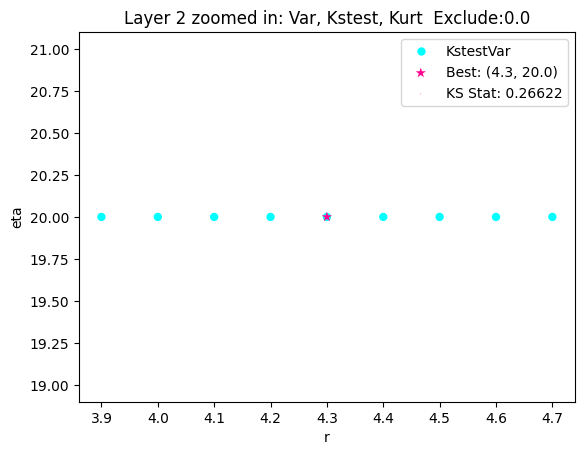

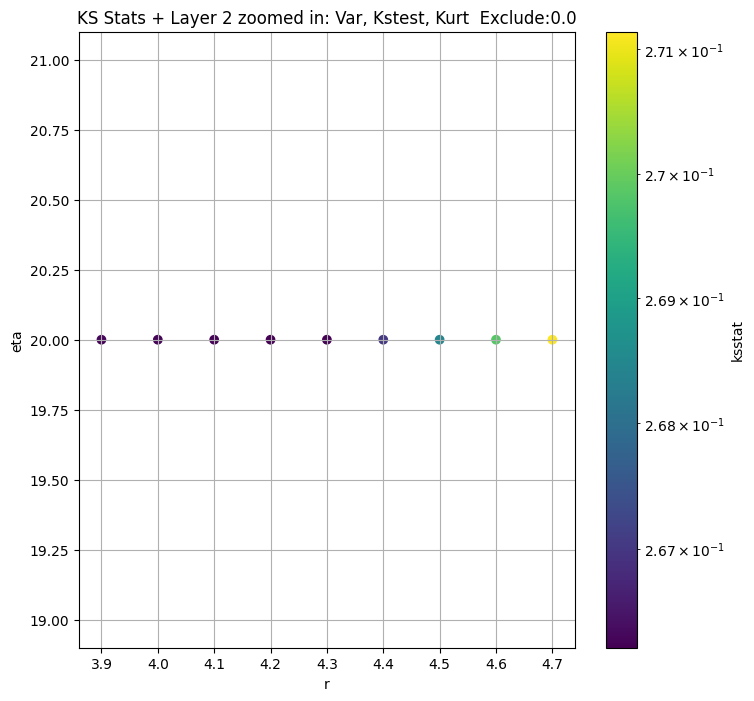

Layer 3


100%|██████████| 99/99 [00:00<00:00, 1226.69it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.09171267898321406, var: 713251.0


100%|██████████| 99/99 [00:00<00:00, 1401.02it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.09112934364941977, var: 717541.0


100%|██████████| 99/99 [00:00<00:00, 1424.19it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.09052100508991323, var: 722051.5


100%|██████████| 99/99 [00:00<00:00, 1450.69it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.08987749917087595, var: 726981.4375


100%|██████████| 99/99 [00:00<00:00, 1439.20it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0885707052636922, var: 736888.25
Number of samples: 20050, Without approximation : 20050.0


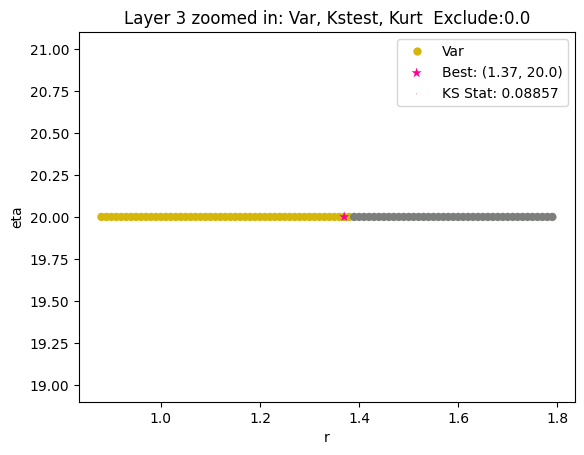

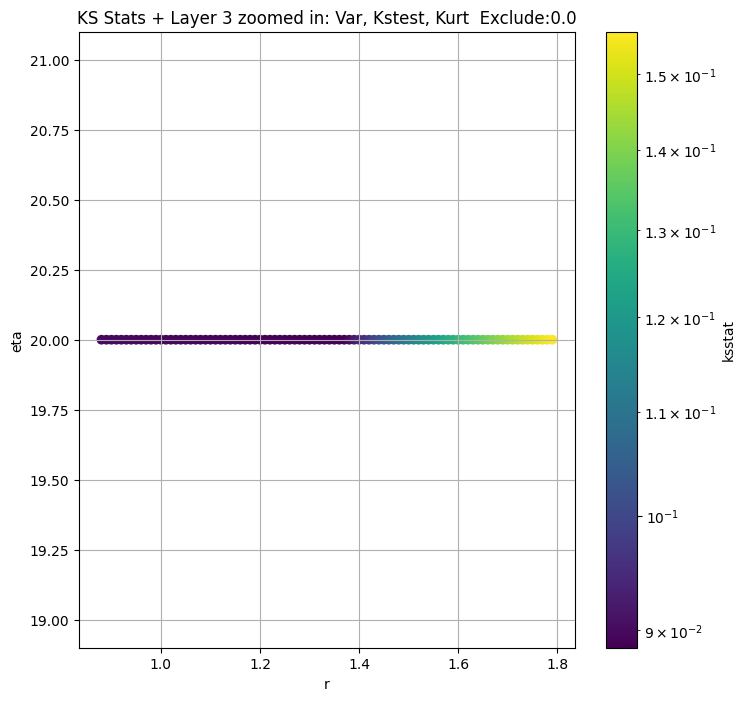

Layer 4


100%|██████████| 68/68 [00:00<00:00, 278.49it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 100 = 350, ksstat: 0.01455327203381998, var: 438235.46875


100%|██████████| 68/68 [00:00<00:00, 302.74it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 75 = 325, ksstat: 0.014400604828774144, var: 439980.5625


100%|██████████| 68/68 [00:00<00:00, 302.61it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 50 = 300, ksstat: 0.01424632134895476, var: 441740.59375


100%|██████████| 68/68 [00:00<00:00, 302.34it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 25 = 275, ksstat: 0.014075795482979658, var: 443516.0


100%|██████████| 68/68 [00:00<00:00, 300.24it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 0 = 250, ksstat: 0.01385525325084784, var: 445311.03125


100%|██████████| 68/68 [00:00<00:00, 301.67it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -25 = 225, ksstat: 0.014138795725518072, var: 447123.46875


100%|██████████| 68/68 [00:00<00:00, 299.37it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -50 = 200, ksstat: 0.014279604965245163, var: 448952.90625


100%|██████████| 68/68 [00:00<00:00, 300.87it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -75 = 175, ksstat: 0.01425852071883249, var: 450806.40625


100%|██████████| 68/68 [00:00<00:00, 300.97it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -100 = 150, ksstat: 0.014671012858330626, var: 452692.75
Number of samples: 100000, Without approximation : 180942.0


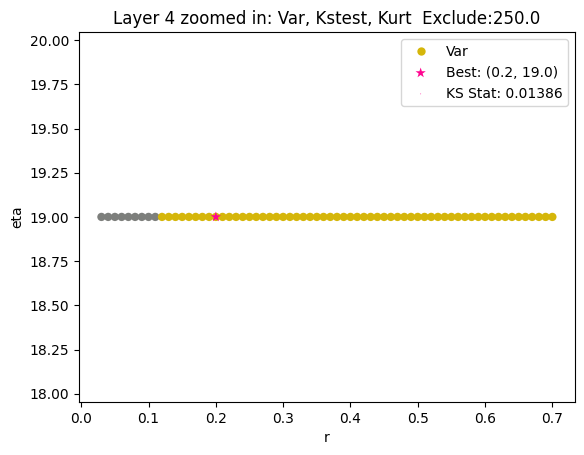

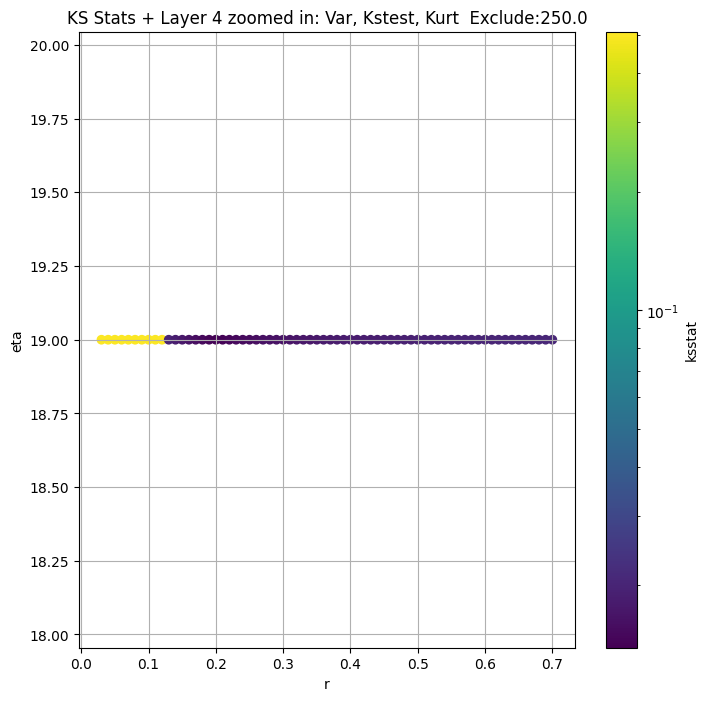

Layer 5


100%|██████████| 1800/1800 [00:06<00:00, 287.48it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.005453902880837802, var: 101586.140625


100%|██████████| 1800/1800 [00:06<00:00, 298.78it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.005119174169089996, var: 102567.546875


100%|██████████| 1800/1800 [00:06<00:00, 286.00it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.004762662393538439, var: 103606.3359375


100%|██████████| 1800/1800 [00:06<00:00, 296.50it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.004393820876313126, var: 104718.359375


100%|██████████| 1800/1800 [00:06<00:00, 293.71it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.003998311427054202, var: 105914.6875


100%|██████████| 1800/1800 [00:06<00:00, 271.84it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0038364707350679317, var: 107235.1171875


100%|██████████| 1800/1800 [00:06<00:00, 276.68it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.0038983998544613874, var: 108863.671875
Number of samples: 100000, Without approximation : 922650.0


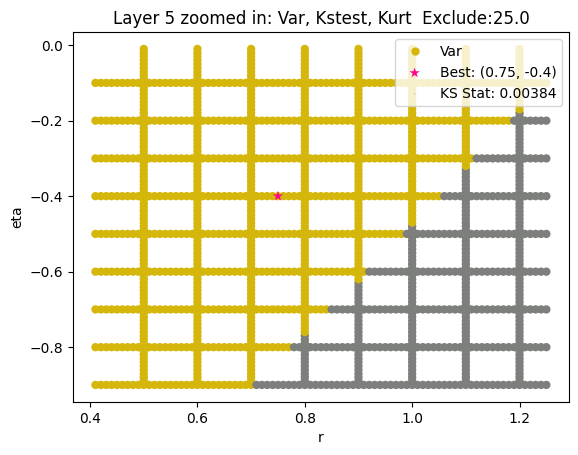

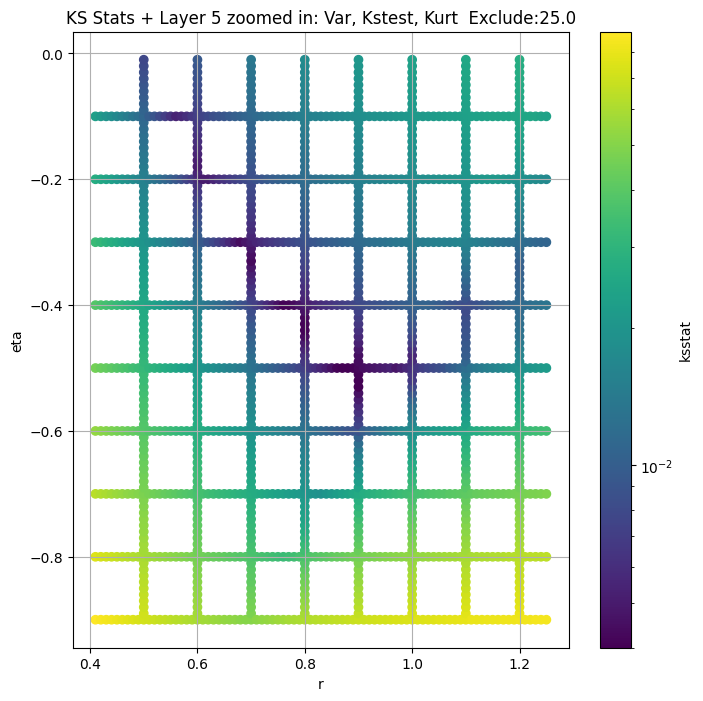

Layer 6


100%|██████████| 1900/1900 [00:06<00:00, 277.86it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 100 = 450, ksstat: 0.008846044076091113, var: 38623.5078125


100%|██████████| 1900/1900 [00:06<00:00, 293.14it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 75 = 425, ksstat: 0.00863913034118624, var: 39002.49609375


100%|██████████| 1900/1900 [00:06<00:00, 294.12it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 50 = 400, ksstat: 0.008428900273560802, var: 39388.69140625


100%|██████████| 1900/1900 [00:06<00:00, 290.28it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 25 = 375, ksstat: 0.008215251918643807, var: 39782.4375


100%|██████████| 1900/1900 [00:06<00:00, 275.18it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 0 = 350, ksstat: 0.008028425237794914, var: 40184.36328125


100%|██████████| 1900/1900 [00:06<00:00, 281.58it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -25 = 325, ksstat: 0.007813601524568337, var: 40594.4375


100%|██████████| 1900/1900 [00:06<00:00, 288.52it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -50 = 300, ksstat: 0.007612912246127312, var: 41013.265625


100%|██████████| 1900/1900 [00:06<00:00, 290.88it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -75 = 275, ksstat: 0.0073860357502261165, var: 41441.34375


100%|██████████| 1900/1900 [00:06<00:00, 284.78it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -100 = 250, ksstat: 0.007448559651371173, var: 41879.58203125
Number of samples: 100000, Without approximation : 4185552.0


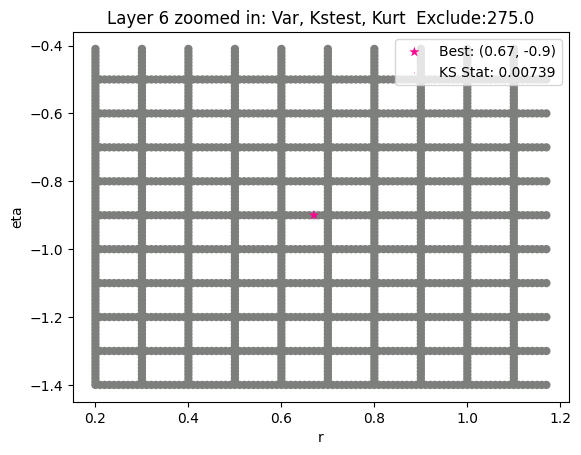

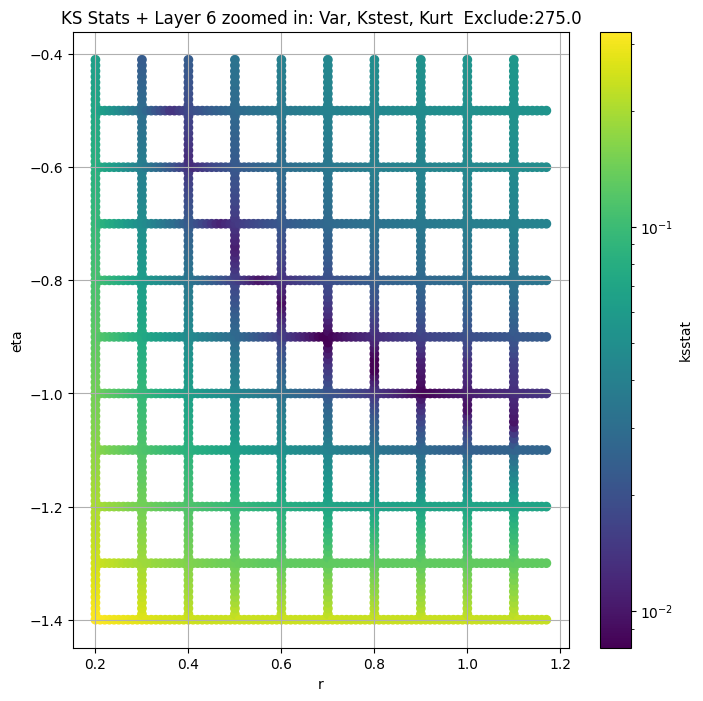

Layer 7


100%|██████████| 1570/1570 [00:05<00:00, 286.45it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.010039620700232923, var: 8545.3623046875


100%|██████████| 1570/1570 [00:05<00:00, 281.90it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.009799267693570115, var: 8631.3671875


100%|██████████| 1570/1570 [00:05<00:00, 291.59it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.009767238243930554, var: 8720.5966796875


100%|██████████| 1570/1570 [00:05<00:00, 290.86it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.009653253275930473, var: 8813.8212890625


100%|██████████| 1570/1570 [00:05<00:00, 293.88it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.009754353725120346, var: 8912.322265625


100%|██████████| 1570/1570 [00:05<00:00, 292.31it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.009391396677494224, var: 9018.7607421875


100%|██████████| 1570/1570 [00:05<00:00, 294.41it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.009391099510282053, var: 9147.3701171875
Number of samples: 100000, Without approximation : 17688454.0


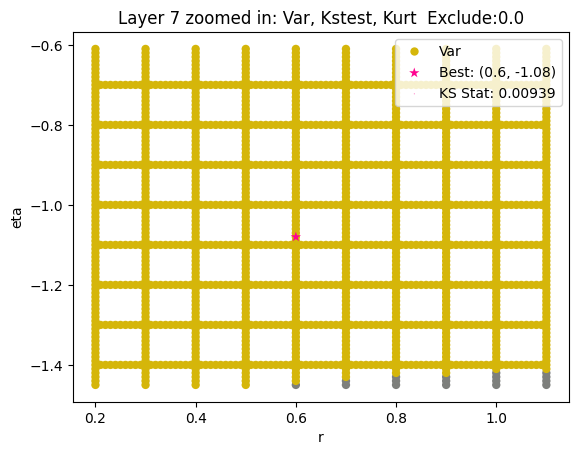

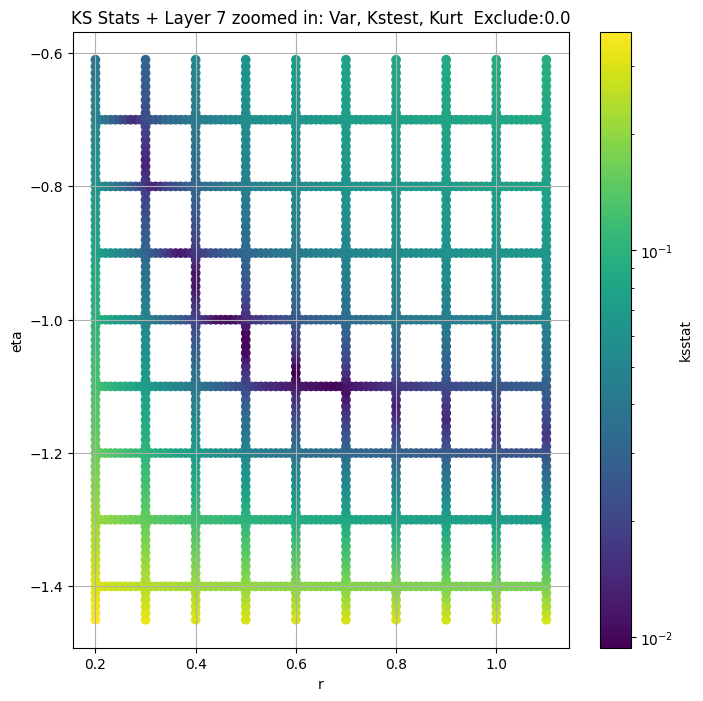

Layer 8


100%|██████████| 1480/1480 [00:05<00:00, 293.25it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.014935534247717597, var: 849.7289428710938


100%|██████████| 1480/1480 [00:06<00:00, 242.30it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.014935410991784304, var: 860.555419921875


100%|██████████| 1480/1480 [00:05<00:00, 280.26it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.014935441358324586, var: 872.0584716796875


100%|██████████| 1480/1480 [00:05<00:00, 283.35it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.014935473420558787, var: 884.4559936523438


100%|██████████| 1480/1480 [00:05<00:00, 286.42it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.014935508406510256, var: 898.2880859375


100%|██████████| 1480/1480 [00:05<00:00, 291.56it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.014935558961535977, var: 918.8560180664062
Number of samples: 100000, Without approximation : 72685058.0


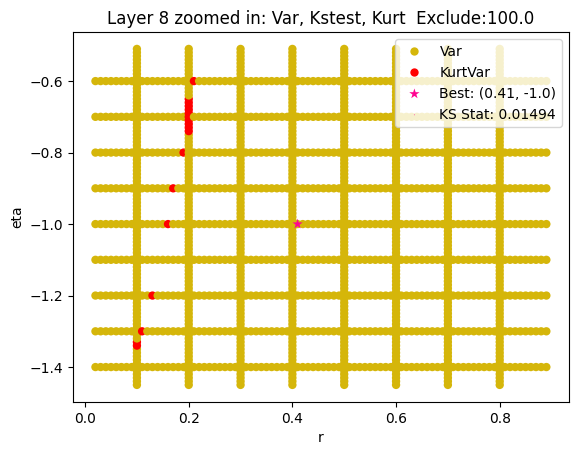

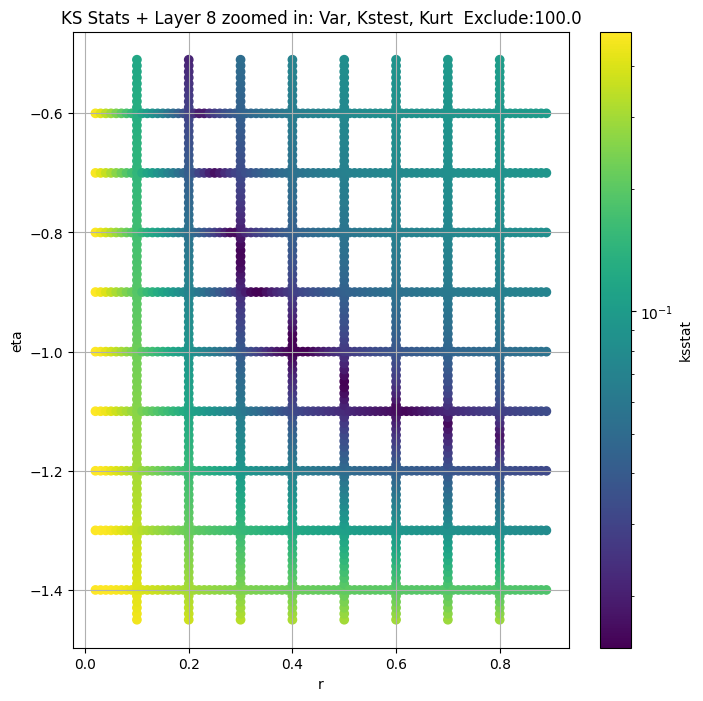

Layer 9


100%|██████████| 1125/1125 [00:04<00:00, 276.83it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + 100 = 450, ksstat: 0.09078024931725093, var: 55.73033905029297


100%|██████████| 1125/1125 [00:04<00:00, 268.46it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + 75 = 425, ksstat: 0.09078028770838609, var: 56.48033142089844


100%|██████████| 1125/1125 [00:03<00:00, 285.87it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + 50 = 400, ksstat: 0.0907802828317511, var: 57.25754928588867


100%|██████████| 1125/1125 [00:03<00:00, 284.69it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + 25 = 375, ksstat: 0.09078023369580268, var: 58.06488800048828


100%|██████████| 1125/1125 [00:03<00:00, 291.48it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + 0 = 350, ksstat: 0.09078013172264665, var: 58.90205001831055


100%|██████████| 1125/1125 [00:03<00:00, 288.18it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + -25 = 325, ksstat: 0.09077997503289686, var: 59.7720832824707


100%|██████████| 1125/1125 [00:03<00:00, 286.93it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + -50 = 300, ksstat: 0.09077976858204051, var: 60.681671142578125


100%|██████████| 1125/1125 [00:03<00:00, 288.45it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + -75 = 275, ksstat: 0.09078065606639385, var: 61.6298828125


100%|██████████| 1125/1125 [00:03<00:00, 286.82it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 350.0 + -100 = 250, ksstat: 0.09078038640477692, var: 62.62108612060547
Number of samples: 100000, Without approximation : 295085108.0


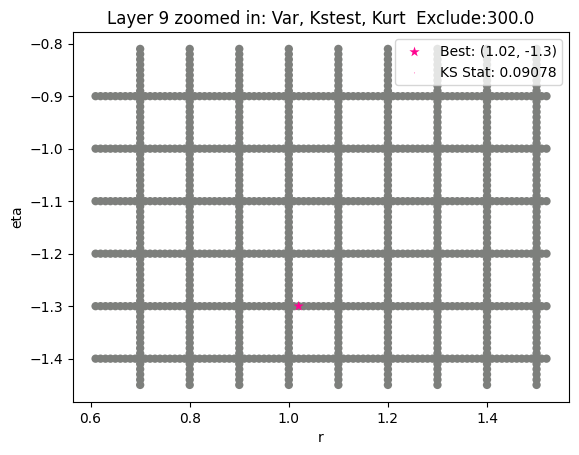

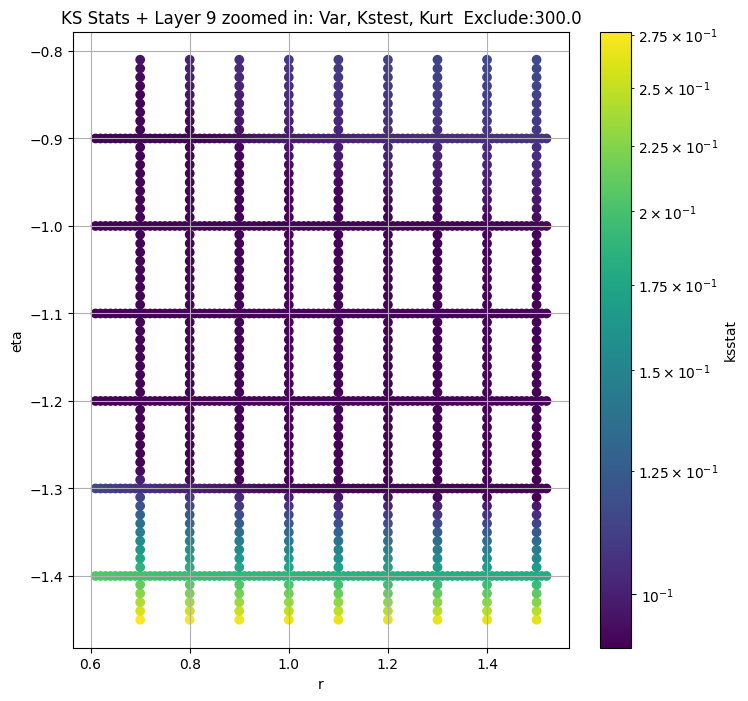

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      141835.42000       0.000000  209363.500000  -1.773327         NaN   
3      736888.25000  720600.400000  753057.440000  -1.273360   -1.335994   
4      465364.94000  445307.280000  485416.300000   0.833817    0.715541   
5      108863.67000  102563.990000  115377.720000   3.237579    2.714865   
6       47217.00800   43791.793000   50738.293000   6.127006    5.564620   
7        9147.37000    8511.857000    9801.893000   5.521395    5.010843   
8         918.85600     848.677900     993.557400   7.177231    5.903591   
9          78.33318      70.408485      87.402626  15.242443   10.448604   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.266217        4.3         20.0   
3       -1.193485        20050.0             0.088687        1.3         20.0   
4        0.964410       180942.0             0.013855        0.2         19.0   
5        3.808384       922650.0             0.004236        0.9         -0.5   
6        6.721844      4185552.0             0.008058        0.7         -0.9   
7        6.145352     17688454.0             0.009754        0.7         -1.1   
8       11.476420     72685058.0             0.014936        0.4         -1.0   
9       33.768715    295085108.0             0.090784        1.1         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       99337.412875                     0.0       141835.420000   
3       85588.526590                     0.0       736888.250000   
4           0.000036                   250.0       445311.030000   
5       89923.328320                    50.0       107235.117188   
6       38411.014943                   350.0        41441.343750   
7       13890.576442                    50.0         9147.370117   
8         184.086068                    25.0          860.555420   
9         313.148278                   350.0           60.681671   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.623939          0.266217    4.30     20.00   
3                     0.009583          0.088571    1.37     20.00   
4                     0.003192          0.013855    0.20     19.00   
5                     0.001414          0.003836    0.75     -0.40   
6                     0.000664          0.007386    0.67     -0.90   
7                     0.000323          0.009391    0.60     -1.08   
8                     0.000159          0.014935    0.41     -1.00   
9                     0.000079          0.090780    1.02     -1.30   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      99337.412875                  0.0           24  
3      99386.838266                  0.0          234  
4          0.000036                250.0         9540  
5      56647.448282                 25.0       129747  
6      36051.719837                275.0        32699  
7       9766.419303                  0.0        21859  
8        197.721163                100.0         8419  
9        307.621602                300.0          210

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

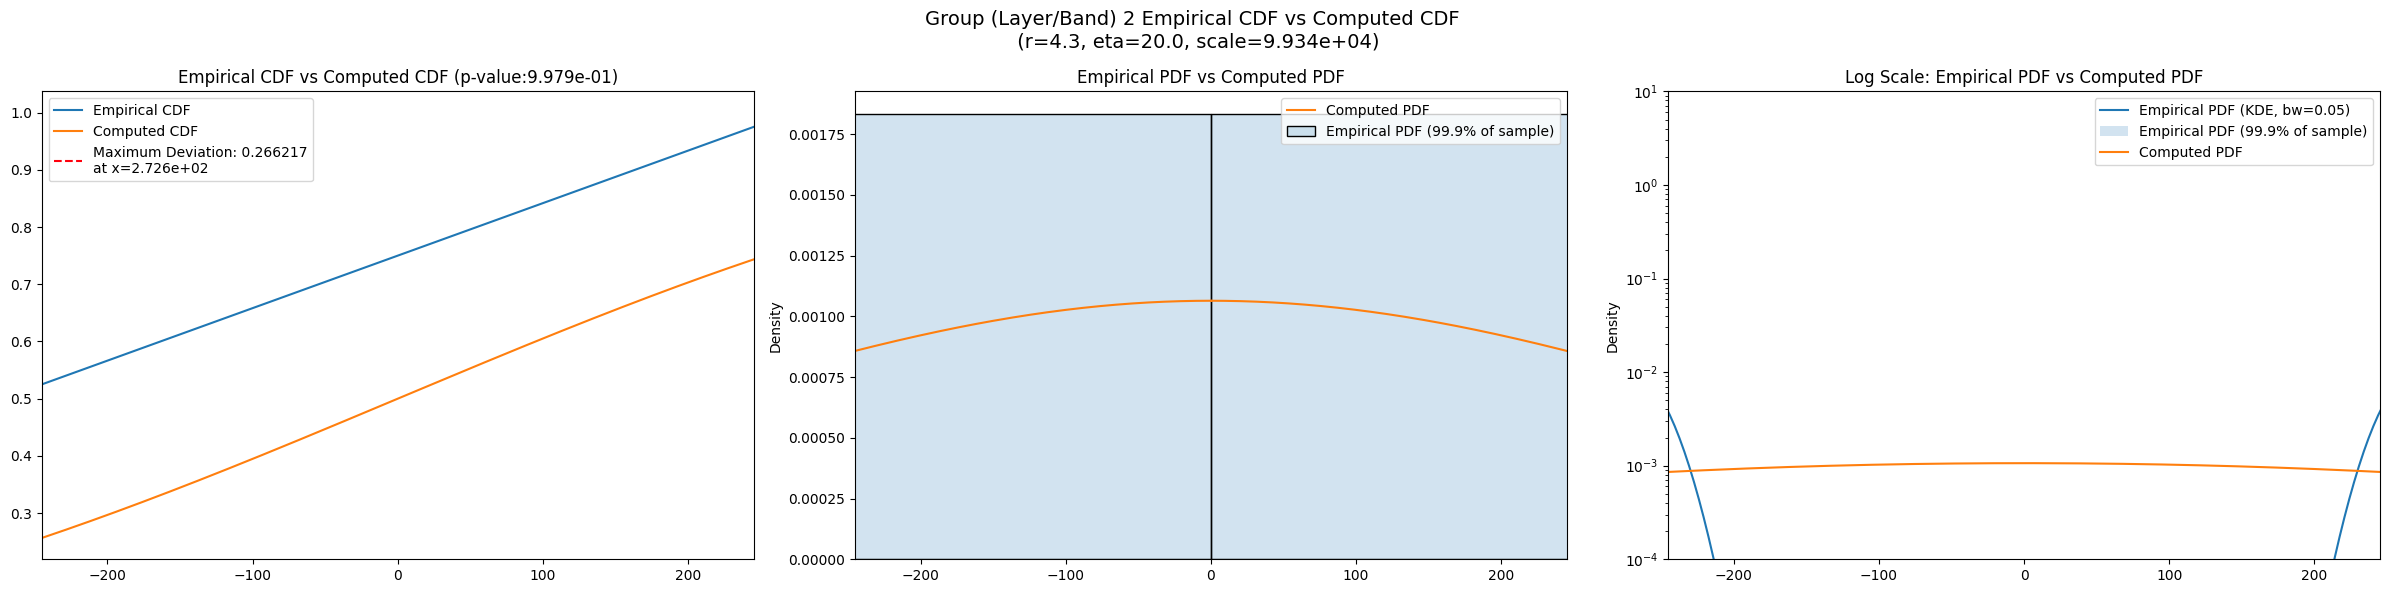

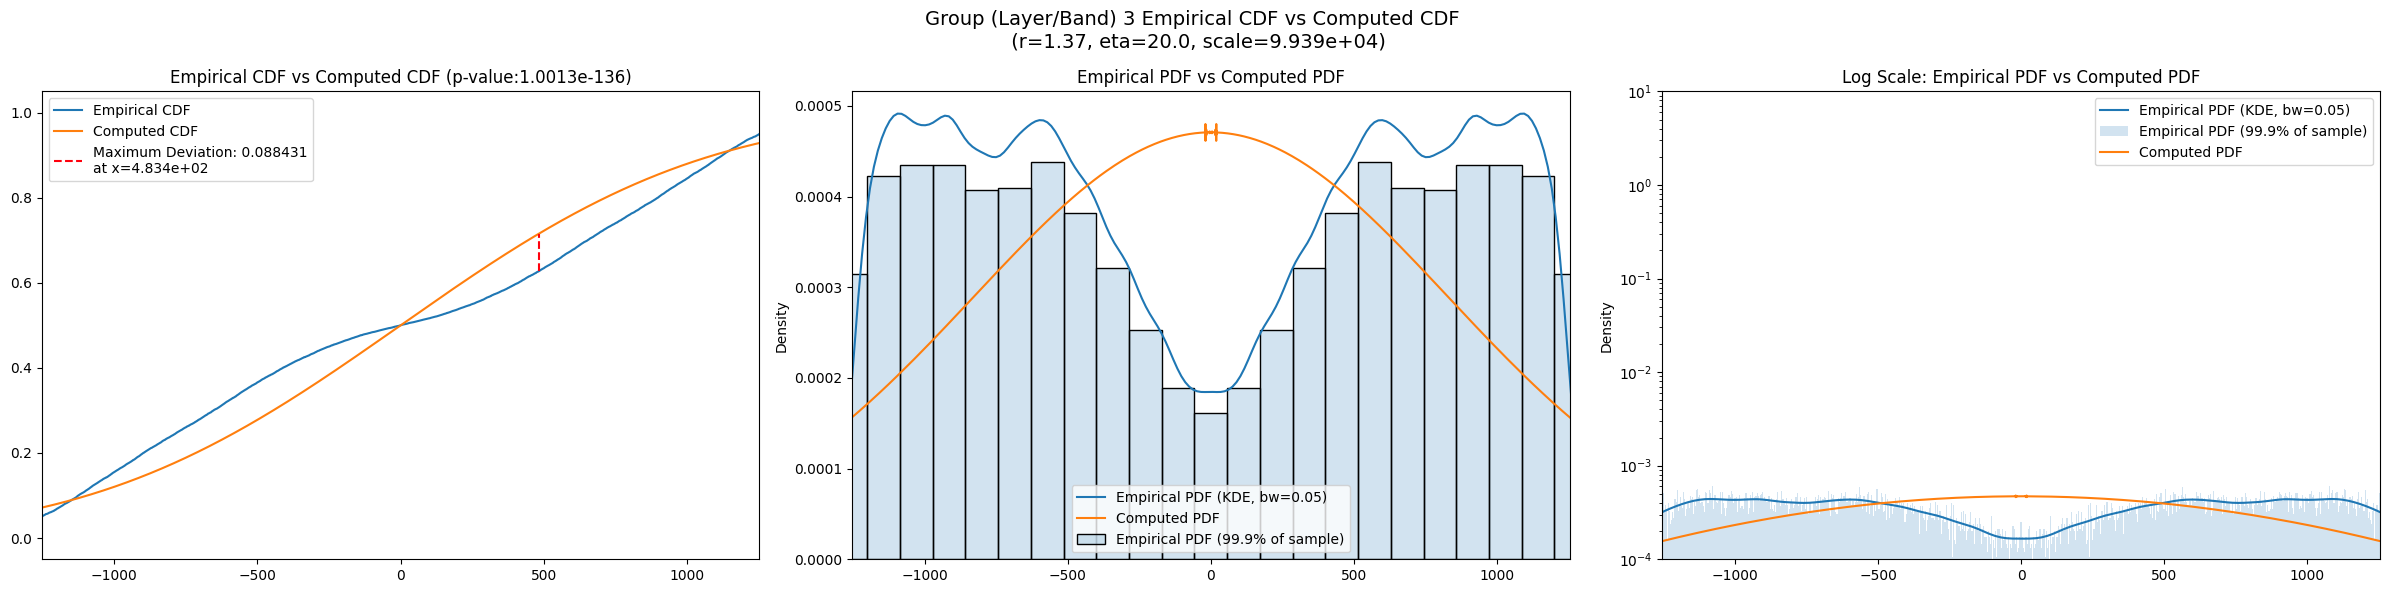

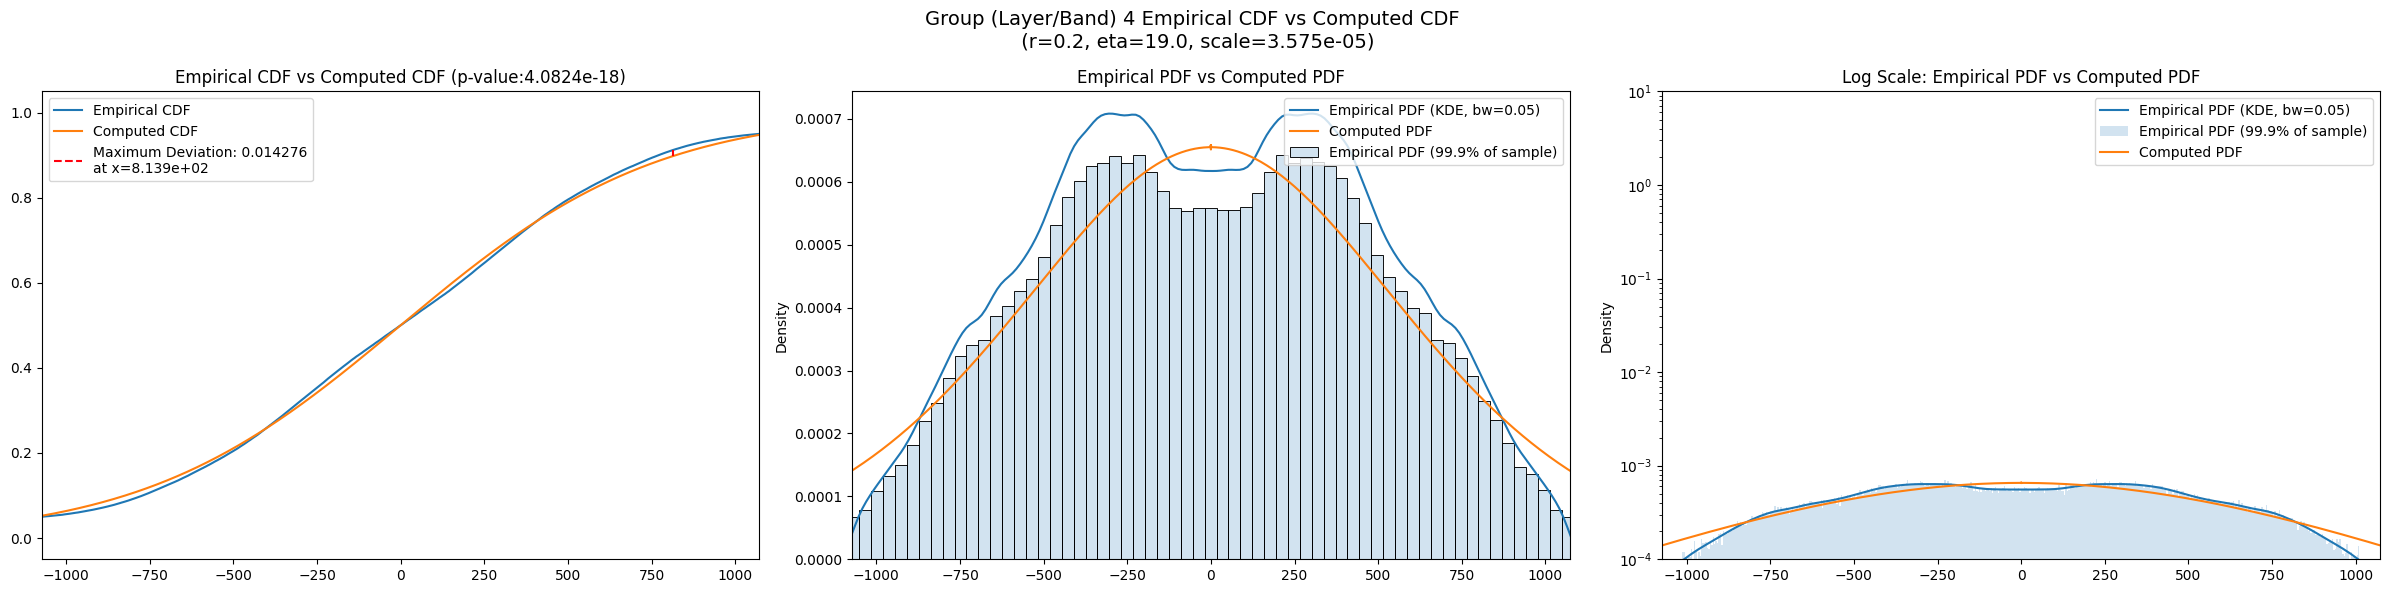

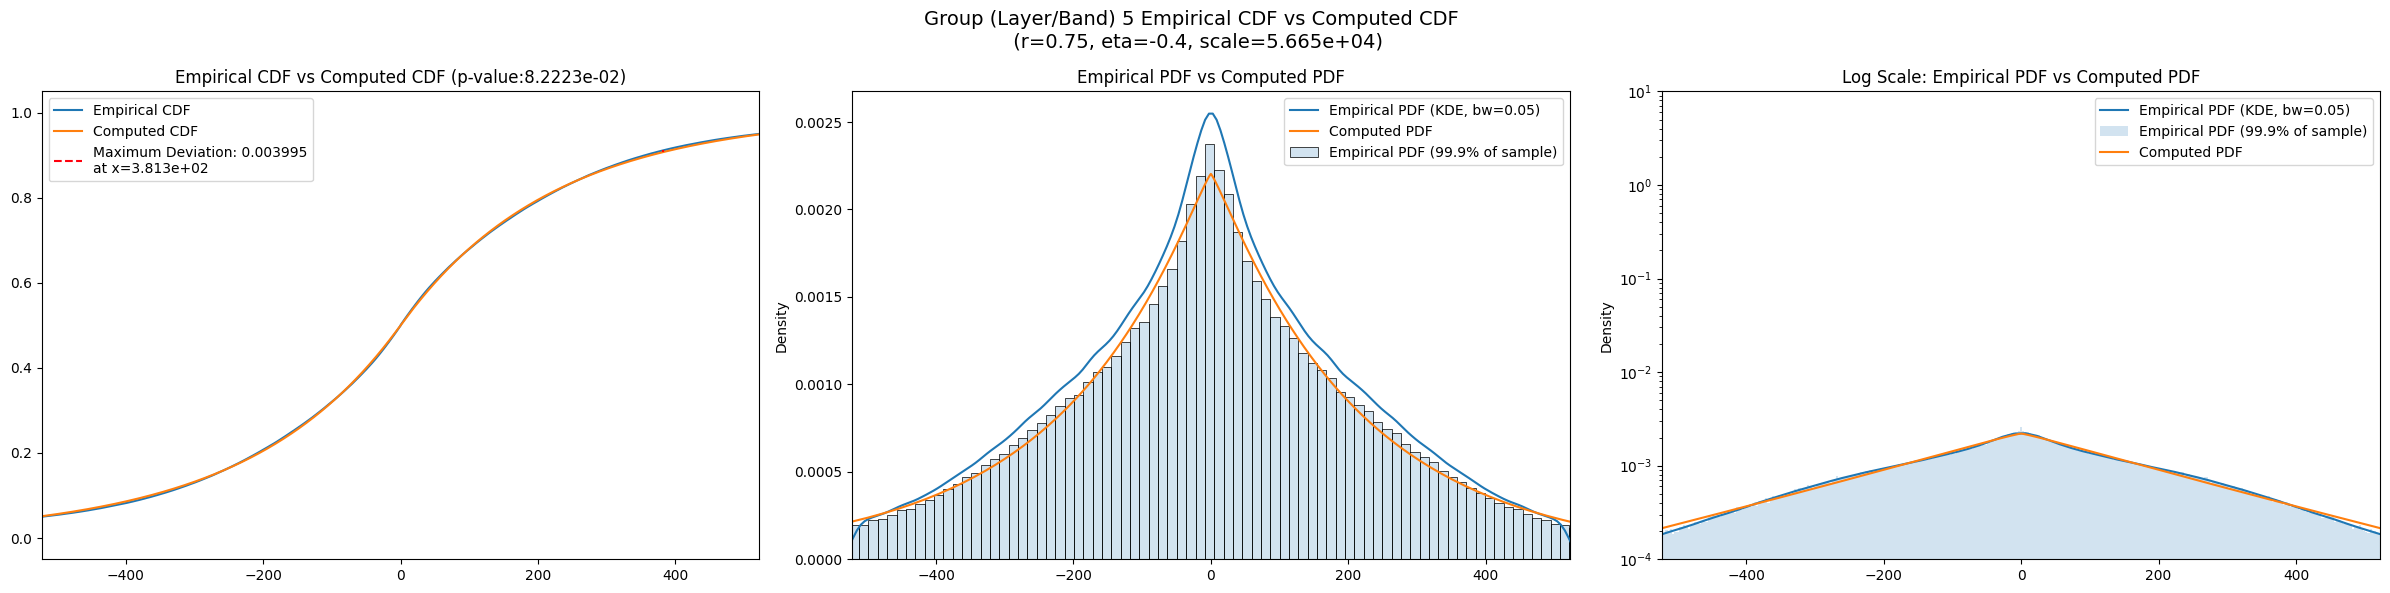

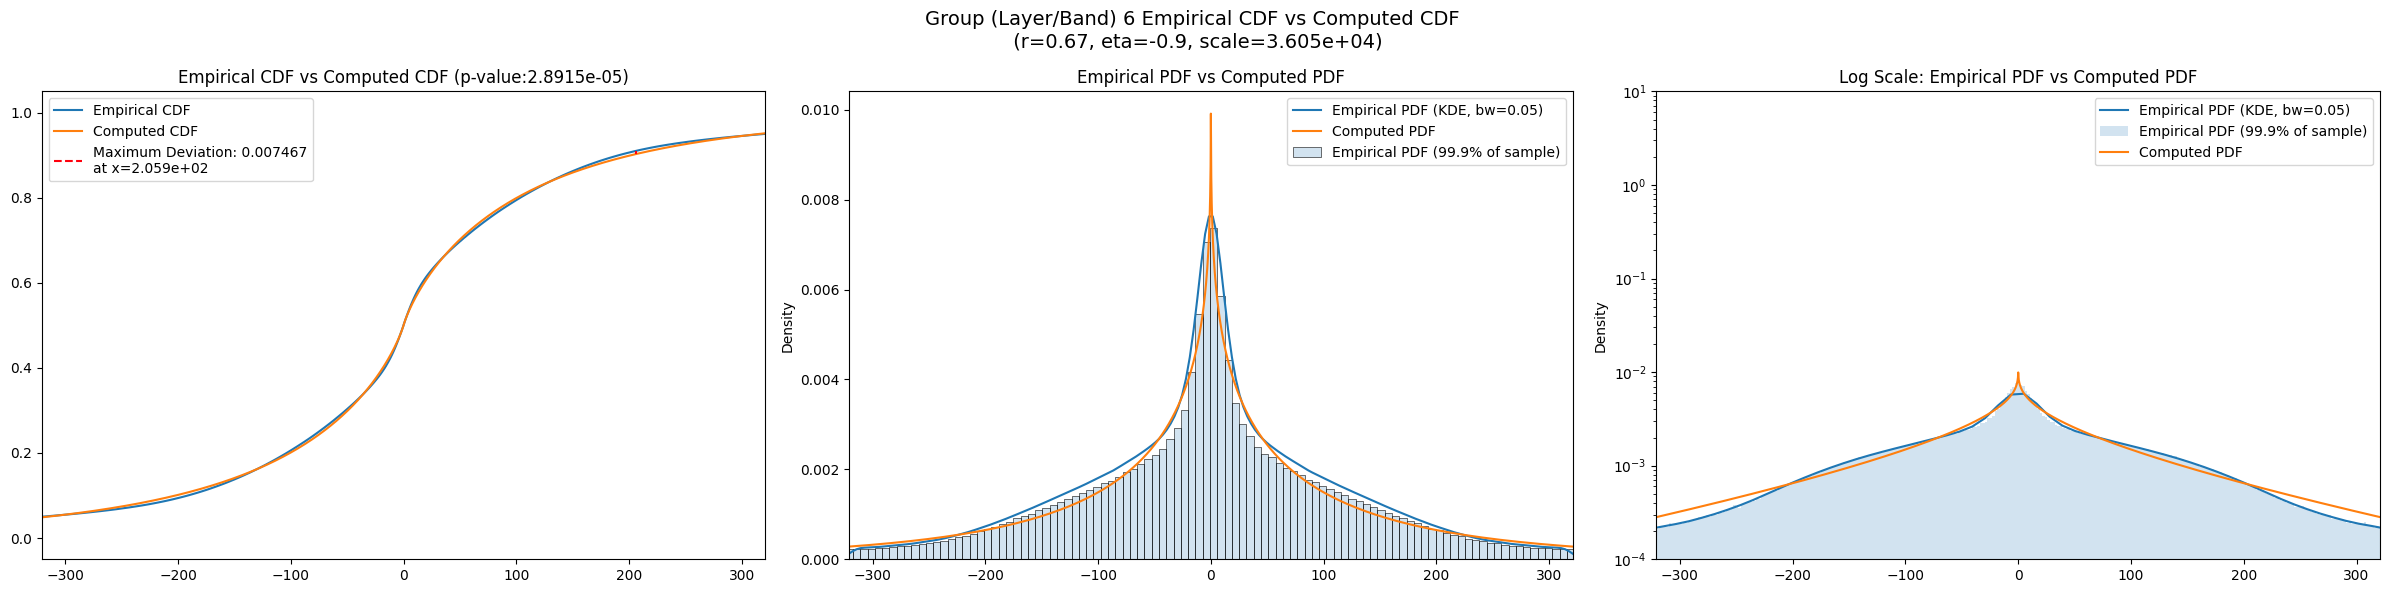

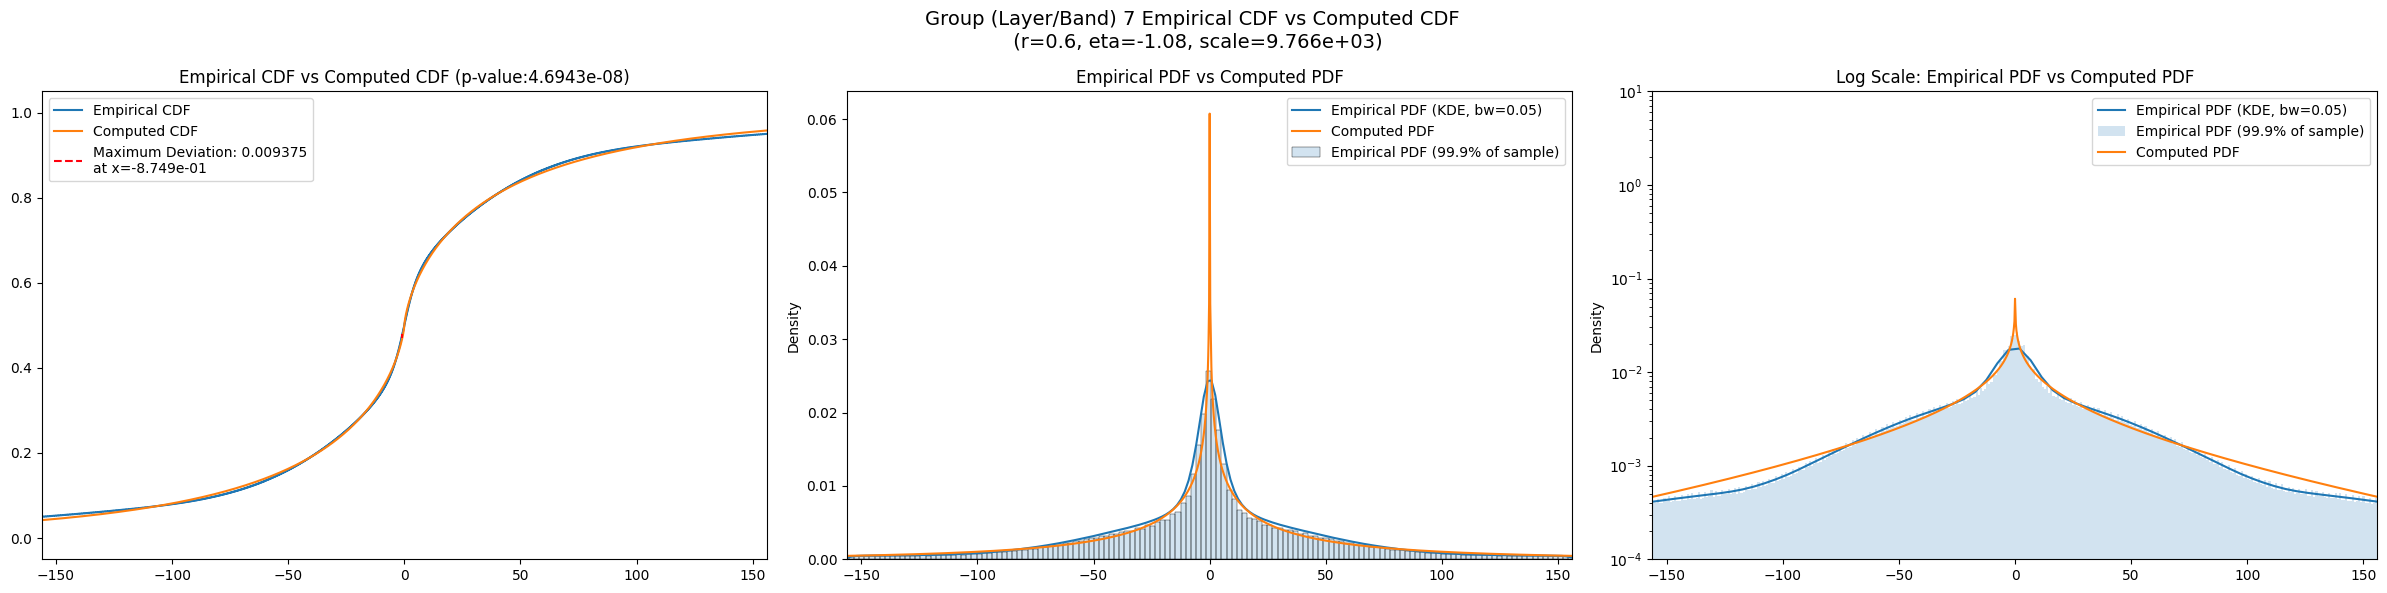

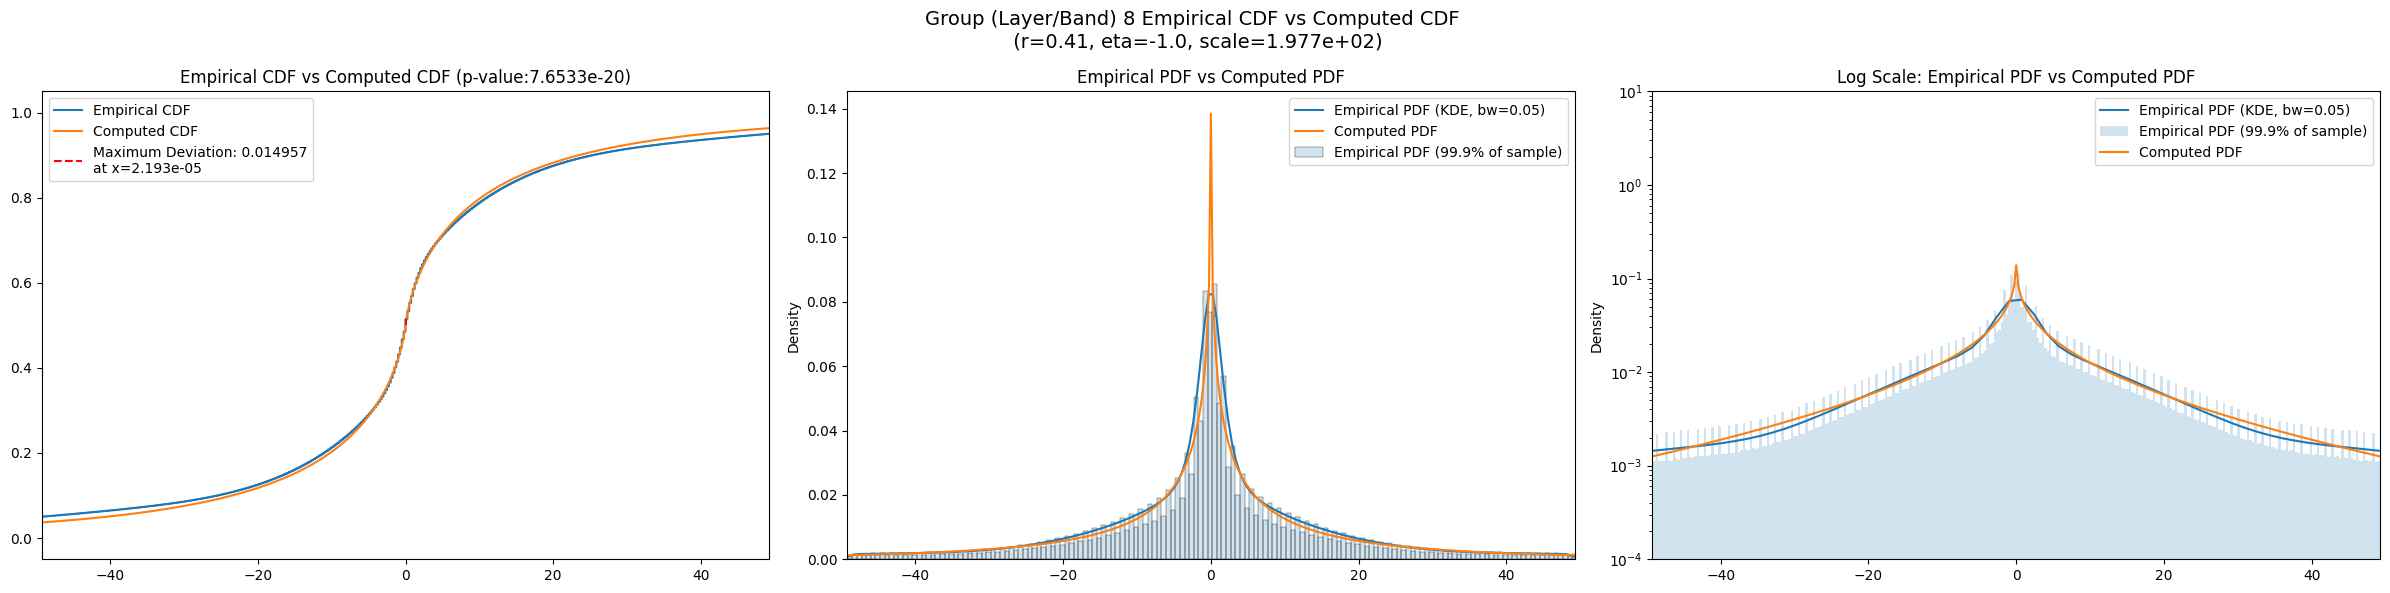

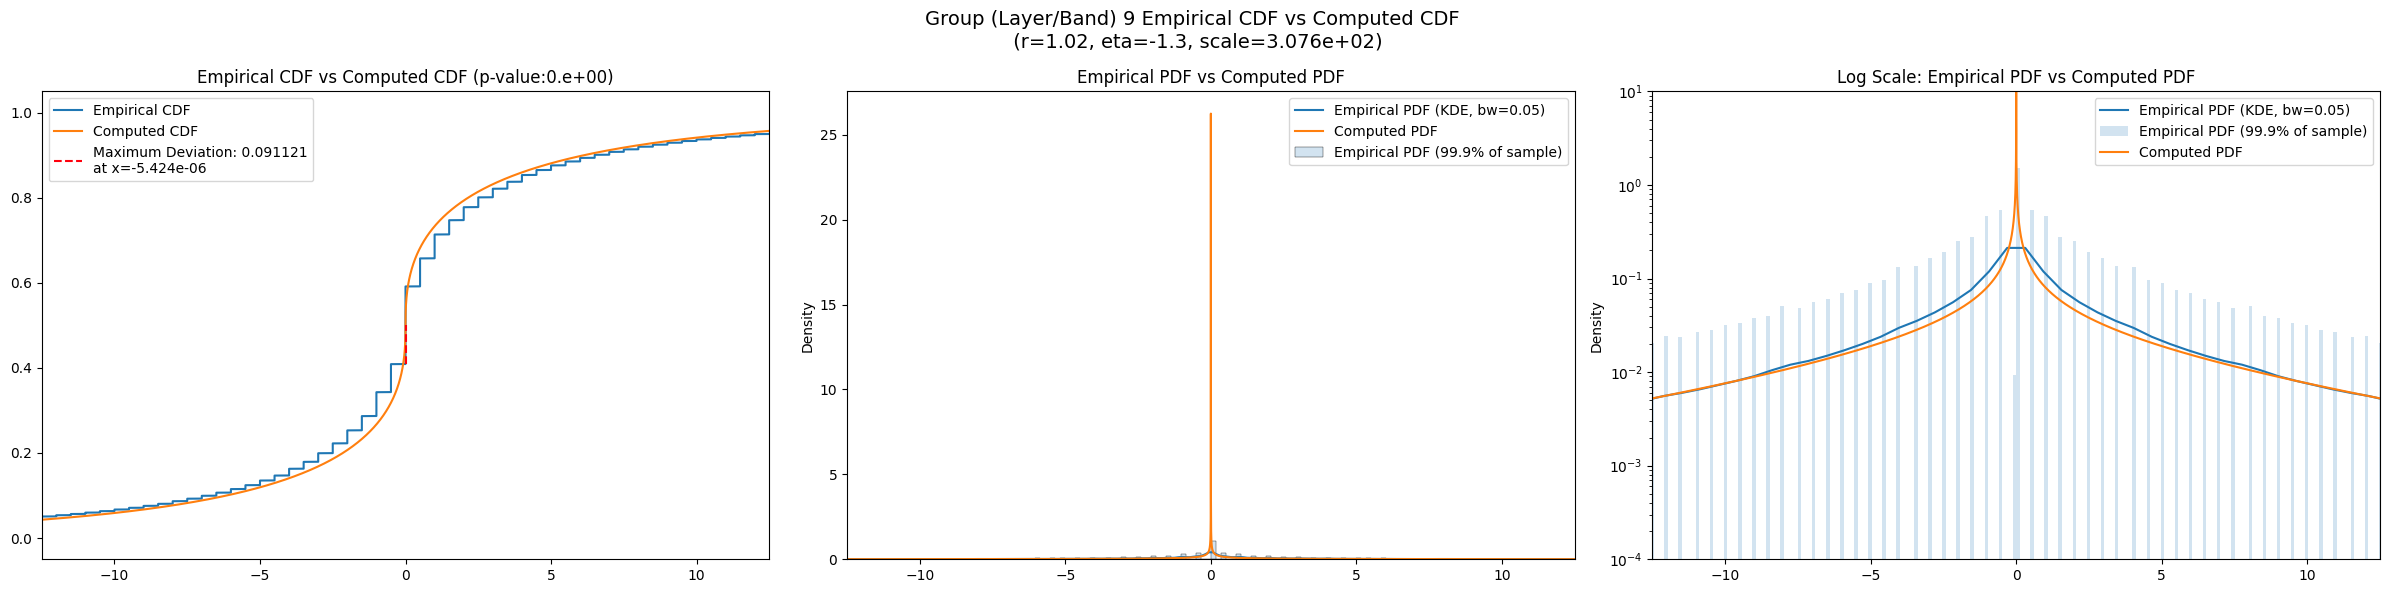

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                      
2      141835.42000       0.000000  209363.500000  -1.773327         NaN   
3      736888.25000  720600.400000  753057.440000  -1.273360   -1.335994   
4      465364.94000  445307.280000  485416.300000   0.833817    0.715541   
5      108863.67000  102563.990000  115377.720000   3.237579    2.714865   
6       47217.00800   43791.793000   50738.293000   6.127006    5.564620   
7        9147.37000    8511.857000    9801.893000   5.521395    5.010843   
8         918.85600     848.677900     993.557400   7.177231    5.903591   
9          78.33318      70.408485      87.402626  15.242443   10.448604   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.266217        4.3         20.0   
3       -1.193485        20050.0             0.088687        1.3         20.0   
4        0.964410       180942.0             0.013855        0.2         19.0   
5        3.808384       922650.0             0.004236        0.9         -0.5   
6        6.721844      4185552.0             0.008058        0.7         -0.9   
7        6.145352     17688454.0             0.009754        0.7         -1.1   
8       11.476420     72685058.0             0.014936        0.4         -1.0   
9       33.768715    295085108.0             0.090784        1.1         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       533.20300              0.195408          9.905630e-01   
3      ...       988.04500              0.061774          5.900830e-67   
4      ...       653.43900              0.018674          3.057770e-55   
5      ...       257.49600              0.029413          0.000000e+00   
6      ...       122.52800              0.049519          0.000000e+00   
7      ...        43.81110              0.068954          0.000000e+00   
8      ...        13.01340              0.076259          0.000000e+00   
9      ...         3.02974              0.091539          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          514.77500             0.205562         9.838250e-01  436.15900   
3          884.43800             0.086358        1.529110e-130  738.21300   
4          570.81800             0.033411        6.418700e-176  473.58100   
5          227.50300             0.005028         1.090180e-20  186.06000   
6          105.04600             0.026913         0.000000e+00   84.19940   
7           38.05930             0.046160         0.000000e+00   29.19250   
8           11.20450             0.052561         0.000000e+00    8.61518   
9            2.06231             0.091207         0.000000e+00    1.70585   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.202110   9.864240e-01          8.671068e-01  
3           0.083621  2.060640e-122         2.626473e-137  
4           0.029036  5.765280e-133          1.334319e-30  
5           0.010500   8.833800e-89          3.194613e-12  
6           0.030942   0.000000e+00         9.294593e-199  
7           0.046581   0.000000e+00          0.000000e+00  
8           0.053306   0.000000e+00          0.000000e+00  
9           0.091208   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.266217                 0.623939          0.266217   
3                 0.088687                 0.009583          0.088571   
4                 0.013855                 0.003192          0.013855   
5                 0.004236                 0.001414          0.003836   
6                 0.008058                 0.000664          0.007386   
7                 0.009754                 0.000323          0.009391   
8                 0.014936                 0.000159          0.014935   
9                 0.090784                 0.000079          0.090780   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.195408             0.205562       0.202110  
3                  0.061774             0.086358       0.083621  
4                  0.018674             0.033411       0.029036  
5                  0.029413             0.005028       0.010500  
6                  0.049519             0.026913       0.030942  
7                  0.068954             0.046160       0.046581  
8                  0.076259             0.052561       0.053306  
9                  0.091539             0.091207       0.091208

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2           141835.420000          0.266217    4.30     20.00  99337.412875   
3           736888.250000          0.088571    1.37     20.00  99386.838266   
4           445311.030000          0.013855    0.20     19.00      0.000036   
5           107235.117188          0.003836    0.75     -0.40  56647.448282   
6            41441.343750          0.007386    0.67     -0.90  36051.719837   
7             9147.370117          0.009391    0.60     -1.08   9766.419303   
8              860.555420          0.014935    0.41     -1.00    197.721163   
9               60.681671          0.090780    1.02     -1.30    307.621602   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                    250.0  
5                     25.0  
6                    275.0  
7                      0.0  
8                    100.0  
9                    300.0

In [21]:
eng.quit()